## AMBER Simulation
### Week 6: 5USZ (JAK2 JH2 in complex with JNJ-7706621)

### Part 1. Preparation of the Janus kinases (JAKs) system

In [ ]:
$ srun -c4 -t4:00:00 --mem=4000 --pty /bin/bash 

In [ ]:
$ module load amber/openmpi/intel/22.03

#### 1.1 Obtain and parse the PDB file

In [ ]:
$ wget https://files.rcsb.org/download/5USZ.pdb

In [ ]:
# Read the pdb text file
# ANISOU records present the anisotropic temperature factors
# Visualize the structure in ChimeraX


In [ ]:
# 5usz.pdb contains chain A and three ligands(DMS, GOL, and SKE)
# We wish to perform the simulation on the apo-protein (without inhibitor) and without the two ligands. We thus have to extract this from the original PDB file.

$ grep "ATOM " 5USZ.pdb > 5USZ_chainA.pdb

In [ ]:
$ grep "HOH " 5USZ.pdb > 5USZ_chainA_XWAT.pdb

#### 1.2 Protonate the protein

In [ ]:
# Protonate the protein - add hydrogen atoms to our system
# use PDB2PQR webserver (https://server.poissonboltzmann.org/pdb2pqr)
# it will optimize the hydrogen bonding network within the protein to determine where the hydrogens should go in the optimal case.
# Generate the 5USZ_chainE.pqr

# Upload the 5USZ_chainE.pqr
# PARSE force field
# AMBER naming scheme
# PROPKA as pKa option
# checked the settings: (1) "Ensure that new atoms are not rebuilt too close to existing atoms", and (2) "Optimize the hydrogen bonding network".

#### 1.3 Add crystal waters, disulfide bonds, solvate the system, and prepare prmtop and inpcrd files using tleap

In [ ]:
# use tleap to add crystal waters, disulfide bonds and solvate the system

$ tleap

In [ ]:
# loads FF14SB the force field parameters for proteins

$ source leaprc.protein.ff14SB

In [ ]:
# loads the parameters for the TIP3P water model

$ source leaprc.water.tip3p

In [ ]:
# loads the GAFF force field for small organic molecules 

$ source leaprc.gaff2

In [ ]:
# Load the protein

$ prot = loadpdb 5USZ_chainA.pqr

# total atoms in file: 4383

In [ ]:
# Renumber the protein residue starting from 1 instead of 16 in .pqr file
# Make the numbering continuously instead of missing some residues
# For the uncertain residue, keep the first one by defualt 
# Generate 5USZ_chainA_renum.pdb

$ savepdb prot 5USZ_chainA_renum.pdb

# Warning:  Converting N-terminal residue name to PDB format: NPHE -> PHE
# Warning:  Converting C-terminal residue name to PDB format: CLEU -> L

In [ ]:
$ quit

# Exiting LEaP: Errors = 2; Warnings = 2; Notes = 0.

#####  Bond the disulfide in tleap

In [ ]:
# bond the disulfide in tleap

$ tleap

In [ ]:
# use the ff14SB force field

$ source leaprc.protein.ff14SB

In [ ]:
$ source leaprc.water.tip3p

In [ ]:
$ source leaprc.gaff2

In [ ]:
$ prot = loadpdb 5USZ_chainA_renum.pdb

# total atoms in file: 4383

In [ ]:
# check if there are any disulfide bonds
# No CYX, no disulfide

In [ ]:
$ xwat = loadpdb 5USZ_chainA_XWAT.pdb

# Loading PDB file: ./5USZ_chainA_XWAT.pdb
# total atoms in file: 214
# Leap added 428 missing atoms according to residue templates:
# 428 H / lone pair

In [ ]:
# combine the protein and waters

$ complex = combine {prot xwat}

In [ ]:
# save amber topology and coordinate files

$ saveamberparm prot 5USZ_noWAT.prmtop 5USZ_noWAT.inpcrd

# Warning: The unperturbed charge of the unit (-2.000000) is not zero.

In [ ]:
# check the charge of the complex system and we need to add ions to neutralize it

$ charge complex

# Total unperturbed charge:  -2.000000
# Total perturbed charge:    -2.000000

In [ ]:
# add Cl- ions to balance out the charges
# The number "0" at the end of our command means that add appropriate number of counter ions to neutralize the whole system.

$ addions2 complex Na+ 0

# Adding 2 counter ions to "complex" using 1A grid
# Grid extends from solute vdw + 1.37  to  7.37
# Resolution:      1.00 Angstrom.
# Calculating grid charges
# Placed Na+ in complex at (15.12, -9.91, 3.29).
# Placed Na+ in complex at (-13.88, 2.09, -9.71).

# Done adding ions.

In [ ]:
# solvate the protein in a TIP3P water box, and we want at least 12 A between our protein 
# surface and the edge of the water box

$ solvatebox complex TIP3PBOX 12.0 

#   Solute vdw bounding box:              53.739 69.664 53.700
#   Total bounding box for atom centers:  77.739 93.664 77.700
#   Solvent unit box:                     18.774 18.774 18.774
#   Total vdw box size:                   81.057 96.666 80.771 angstroms.
#   Volume: 632872.974 A^3 
#   Total mass 317811.548 amu,  Density 0.834 g/cc
#   Added 15699 residues.

In [ ]:
# check the structures and it will show some information or warning or errors.

$ check complex

# check:  Warnings: 55
# Unit is OK.

In [ ]:
# save solvated complex

$ saveamberparm complex 5USZ_sol.prmtop 5USZ_sol.inpcrd

In [ ]:
# save a pdb of the solvated HNC system

$ savepdb complex 5USZ_sol0.pdb

# Exiting LEaP: Errors = 0; Warnings = 58; Notes = 1.

#### 1.4 Minimization of the system

$ srun --tasks-per-node=4 --time=2:00:00 --mem=4GB --pty /bin/bash

In [ ]:
# Create min_sol.in file for minimization of waters
    """
Minimization of water molecules
&cntrl
imin = 1,
maxcyc=5000,
ncyc=3000,
ntb=1,
cut=10,
ntpr=5,
ntr=1, restraintmask=':1-272',
restraint_wt=2.0,
/
    """

In [ ]:
# Create min_all.in file minimization of the whole system
    """
Minimization of the whole system
&cntrl
imin = 1,
maxcyc=10000, ncyc=7000,
ntb=1, ntr=0, cut=10, ntpr=5,
/
    """

In [ ]:
$ module swap amber/openmpi/intel/22.03 amber/openmpi/intel/22.00

In [ ]:
# The -p flag specifies the topology file which contains information about the atoms, residues, bonds



$ mpiexec pmemd.MPI -O -i min_sol.in -o min_sol.out -p 5USZ_sol.prmtop -c 5USZ_sol.inpcrd -r min_sol.rst -ref 5USZ_sol.inpcrd 

In [ ]:
$ mpiexec pmemd.MPI -O -i min_all.in -o min_all.out -p 5USZ_sol.prmtop -c min_sol.rst -r min_all.rst -ref min_sol.rst

In [ ]:
$ ambpdb -p 5USZ_sol.prmtop -c min_all.rst > min_all.pdb

In [ ]:
$ mkdir minall
$ cd minall
$ process_minout.perl ../min_all.out

#### 1.5 Data Analysis

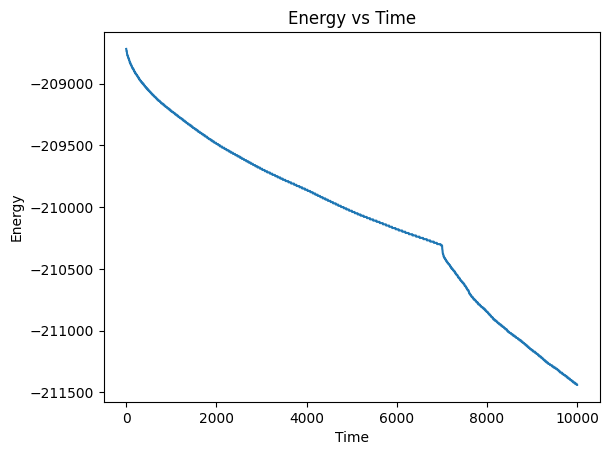

In [1]:
import matplotlib.pyplot as plt

# Specify the file path
file_path = "min/minall/summary.ENERGY"

# Read data from file
time = []
energy = []
with open(file_path, 'r') as file:
    for line in file:
        columns = line.split()
        time.append(float(columns[0]))
        energy.append(float(columns[1]))

# Plot the graph
plt.plot(time, energy)
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy vs Time')
plt.show()

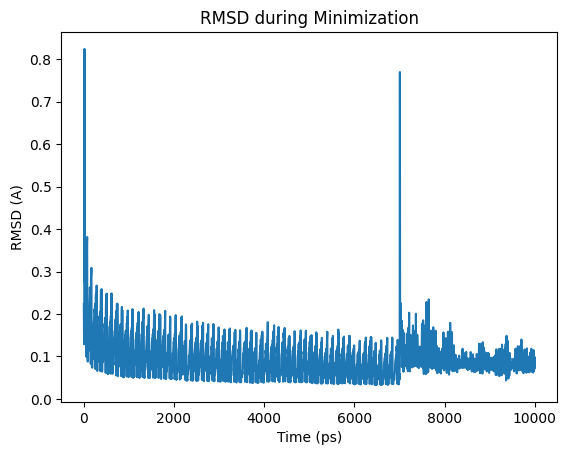

In [11]:
# The RMSD of the system throughout Minimization

file_path = "min/minall/summary.RMS"

# Read data from file
time = []
rms = []
with open(file_path, 'r') as file:
    for line in file:
        columns = line.split()
        time.append(float(columns[0]))
        rms.append(float(columns[1]))

# Plot the graph
plt.plot(time, rms)
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Minimization')
plt.show()


### Part 2: Heating and equilibration

#### 2.1 Heating and equilibration

In [ ]:
# 1. Heating of the system from 10 K to 300K in 50 ps.(heat.in)
# 2. Equilibrate the system density at 300K at constant pressure for 50 ps.(density.in)
# 3. Equilibrate the system at 300K at constant pressure with lower restraints for 100 ps. (equil.in)

In [ ]:
# create a new folder for heating and equilibration

$ mkdir equ
$ cd equ
$ cp ../min/5USZ_sol.prmtop .
$ cp ../min/min_all.rst .


In [ ]:
# Create heat.in input file
# Heating of protein from 10K to 300K with weak restraints and constant volume

    """
&cntrl 
imin = 0, ! no energy minimization 
irest = 0, ! no restart 
ntx = 1,! no initial velocities will be read 
ig = -1, ! random initial velocities 
nstlim = 25000, ! run for 0.05 ns 
dt = 0.002, ! step length (fs) 
ntc = 2,! bonds involving H are constrained 
ntf = 2, 
cut = 12.0, 
ntb = 1, 
ntpr = 500, 
ntwx = 500,! write the structure every 500th step 
ntt = 3, ! Langevin temperature control
gamma_ln = 2.0, 
tempi = 10.0, ! initial temperature 
temp0 = 300.0, ! reference temperature 
ntr = 1,
restraintmask = ':1-272', 
restraint_wt = 2.0, ! restraint weight 
nmropt = 1,! flag for restraints set below 
ioutfm = 1,! netcdf trajectory 
/
&wt TYPE='TEMP0', istep1=0, istep2=25000, 
value1=0.1, value2=300.0, / 
&wt TYPE='END' /
    """


In [ ]:
# Create density.in file
# Equilibrate the system density at 300K at constant pressure for 50 ps.

    """    
&cntrl 
imin=0, 
irest=1, ! restart the simulation from last run 
ntx=5, 
nstlim=25000, dt=0.002, 
ntc=2,ntf=2, 
cut=8.0, ntb=2, 
ntp=1, taup=1.0,! constant pressure 
ntpr=500, ntwx=500, 
ntt=3, gamma_ln=2.0, 
temp0=300.0, 
ntr=1, restraintmask=':1-272', 
restraint_wt=2.0, 
ioutfm = 1, 
/
    """


In [ ]:
# Create equil.in
# Equilibrate the system at 300K at constant pressure with lower restraints for 100 ps 

    """
&cntrl 
imin = 0, irest = 1,ntx = 5, nstlim = 50000, dt = 0.002, 
ntc = 2, ntf = 2, 
cut = 10.0, ntb = 2, ntp = 1, taup=2.0, 
ntpr = 500, ntwx = 500, 
ntt = 3, gamma_ln = 2.0, 
temp0 = 300.0, 
ntr = 1, restraintmask = ':1-272', 
restraint_wt = 0.5, 
ioutfm = 1, 
/
    """


In [ ]:
# Make amberjob1.sbatch file

    """
#SBATCH --job-name=Amber
#SBATCH --nodes=1
#SBATCH --tasks-per-node=20
#SBATCH --time=48:00:00
#SBATCH --mem=20GB


# Comments start here, above are not comments and should be in your script 
# go to your working directory: /scratch/qo210/mygaussianproject/Week4/HNE/equ  
cd /scratch/qo210/mygaussianproject/Week4/HNE/equ    

# load module to run amber

module purge
module load amber/openmpi/intel/20.11 

# run heating job
srun pmemd.MPI -O -i heat.in -o heat.out -p HNE_sol.prmtop -c min_all.rst -r heat.rst -x heat.mdcrd -ref min_all.rst

# run density job
srun pmemd.MPI -O -i density.in -o density.out -p HNE_sol.prmtop   -c heat.rst -r density.rst -x density.mdcrd -ref min_all.rst

# run equil job
srun pmemd.MPI -O -i equil.in -o equil.out -p HNE_sol.prmtop -c density.rst -r equil.rst -x equil.mdcrd -ref min_all.rst
    """


In [ ]:
# Submit the job 
$ sbatch  amberjob1.sbatch

# check job status
$ squeue -j job_id
$ squeue -u qo210

In [ ]:
# File generated: heat.out, density.out, and equil.out


#### 2.2 Analyzing equilibration output files

In [ ]:
# module load amber/openmpi/intel/20.11
# Make a "analysis" subfolder in the equ folder 

In [ ]:
# Generate series of summary files from heat.out, density.out, and equil.out
# process_mdout perl: can process any files and append the results to single summary files
# This includes the potential(.EPTOT), kinetic(.EKTOT) and total energies(.ETOT)
# Also includes temperature, pressure, volume and density

$ process_mdout.perl ../heat.out ../density.out ../equil.out

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

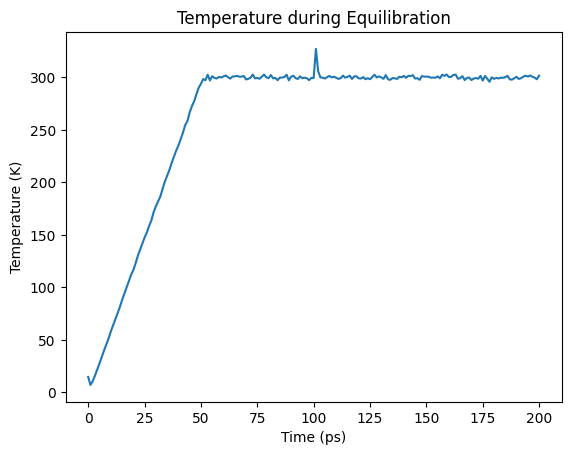

In [4]:
# Plot temperature of the system over the equilibration phase

file_path = "equ/analysis/summary.TEMP"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Equilibration')
plt.show()

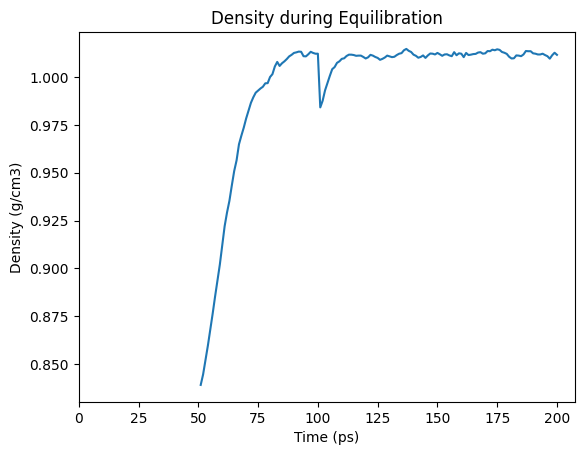

In [5]:
# Plot the density of the system throughout equilibration

file_path = "equ/analysis/summary.DENSITY"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'density'])

# Filter out rows where column 2 is missing
data_filtered = data.dropna(subset=['density'])

# Plot the graph
plt.plot(data_filtered['time'], data_filtered['density'])
plt.xlim(left=0)
plt.xlabel('Time (ps)')
plt.ylabel('Density (g/cm3)')
plt.title('Density during Equilibration')
plt.show()


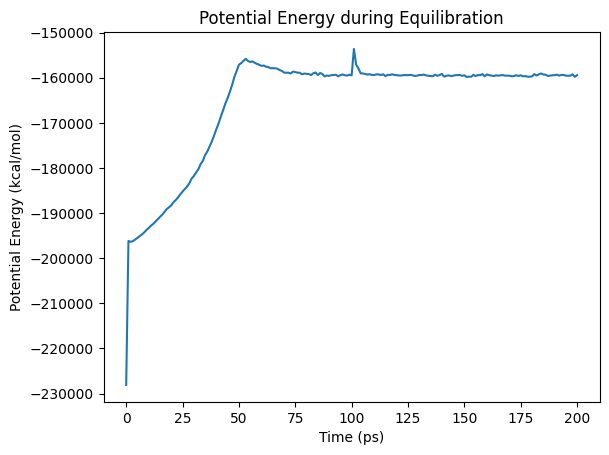

In [6]:
# Graph potential energy of the system throughout equilibration.

file_path = "equ/analysis/summary.EPTOT"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'potential_energy'])

# Plot the graph
plt.plot(data['time'], data['potential_energy'])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kcal/mol)')
plt.title('Potential Energy during Equilibration')
plt.show()

#### 2.3 Analyzing the trajectory
##### Goal: Examine structure change during MD simulations

In [ ]:
# Use cpptraj to calculate root mean square deviation (RMSD) for us as a function of time
# Make initial_rmsd.ptraj input file
# Consider just the main backbone atoms, N, CA, C.

    """
trajin ../heat.mdcrd
trajin ../density.mdcrd 
trajin ../equil.mdcrd 
rms first out 5USZ_equilibration_rms.dat @C,CA,N time 1
    """
# rms means calculate rmsd
# first means reference is the first snapshot
# out HNE_equilibration_rms.dat means output result to file HNE_equilibrium_rms.dat.
# @C,CA,N means using these types of atoms for rmsd calculation.

In [ ]:
# Run cpptraj
# Output file: 5USZ_equilibration_rms.dat
 
$ cpptraj ../5USZ_sol.prmtop initial_rmsd.ptraj

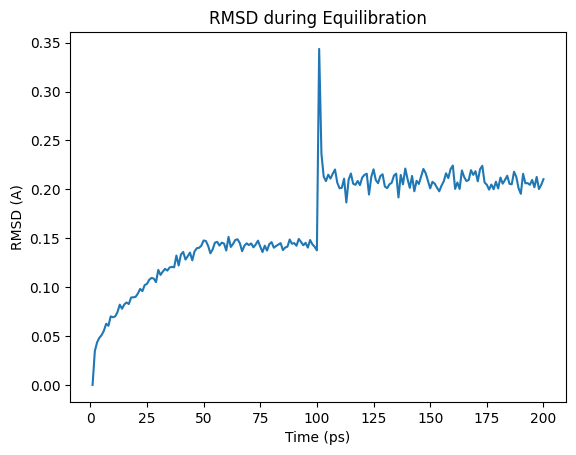

In [7]:
# The RMSD of the system throughout equilibration

file_path = "equ/analysis/5USZ_equilibration_rms.dat"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph
plt.plot(data['#Frame'], data['RMSD_00001'])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Equilibration')

plt.show()

#### 2.4 Re-imaging the trajectory back into the primary box

In [ ]:
# Make reimage.ptraj input file

    """
trajin ../heat.mdcrd
trajin ../density.mdcrd 
trajin ../equil.mdcrd
center :1-272 
image familiar 
rms first @C,CA,N 
trajout equilibration_reimaged.mdcrd
    """

In [ ]:
cpptraj ../5USZ_sol.prmtop reimage.ptraj

# Output file: equilibration_reimaged.mdcrd

### Part 3: MD Production 

In [ ]:
# Make a new md file in Week4

mkdir md
cd md
cp ../equ/5USZ_sol.prmtop .
cp ../equ/equil.rst .


In [ ]:
# Make prod_npt.in input file

    """
MD simulation NPT without restraint
&cntrl 
imin = 0, irest = 1,ntx = 5, nstlim = 1000000, dt = 0.002, 
ntc = 2, ntf = 2, 
cut = 10.0, ntb = 2, ntp = 1, taup=2.0, 
ntpr = 500, ntwx = 500, 
ntt = 3, gamma_ln = 2.0, 
temp0 = 300.0, 
ioutfm = 1, 
/
    """

In [ ]:
# Make an input file amberjob2.sbatch

"""
#!/bin/bash

#SBATCH --job-name=Amber
#SBATCH --nodes=1
#SBATCH --tasks-per-node=20
#SBATCH --time=48:00:00
#SBATCH --mem=20GB

cd /scratch/qo210/mygaussianproject/Week6/md  

module purge

module load amber/openmpi/intel/20.11 

srun pmemd.MPI -O -i prod_npt.in -o prod1.out -p 5USZ_sol.prmtop -c equil.rst -r prod1.rst -x prod1.mdcrd

srun pmemd.MPI -O -i prod_npt.in -o prod2.out -p 5USZ_sol.prmtop -c prod1.rst -r prod2.rst -x prod2.mdcrd
"""


In [ ]:
# Submit the job 
$ sbatch amberjob2.sbatch

# check job status
$ squeue -j job_id
$ squeue -u qo210

### Part 4. Analyzing the trajectory

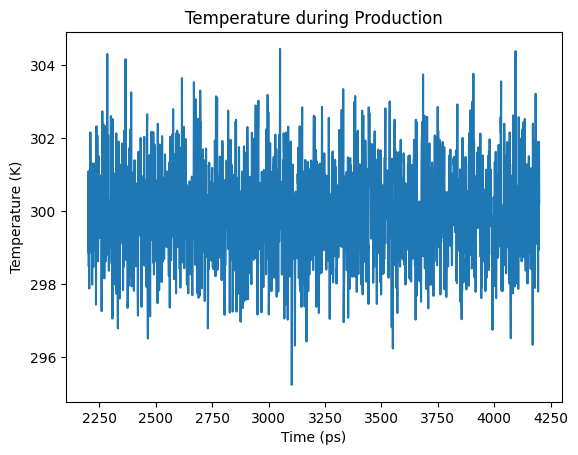

In [4]:
# Temperature of the system throughout production

import matplotlib.pyplot as plt

# Specify the file path
file_path = "md/analysis/summary.TEMP"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'temperature'])

# Plot the graph
plt.plot(data['time'], data['temperature'])
plt.xlabel('Time (ps)')
plt.ylabel('Temperature (K)')
plt.title('Temperature during Production')
plt.show()

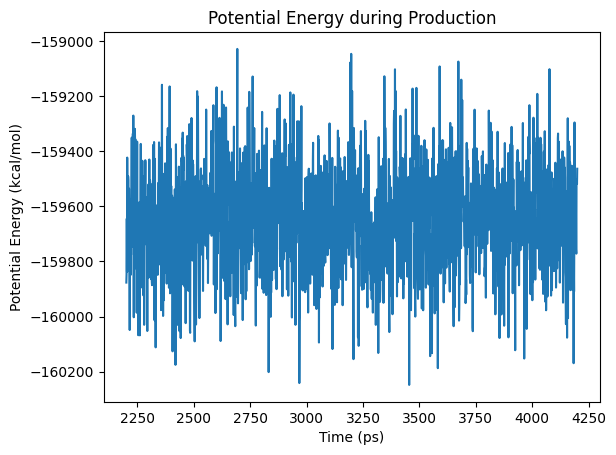

In [5]:
# Graph potential energy of the system throughout production

file_path = "md/analysis/summary.EPTOT"
data = pd.read_csv(file_path, sep="\s+", header=None, names=['time', 'potential_energy'])

# Plot the graph
plt.plot(data['time'], data['potential_energy'])
plt.xlabel('Time (ps)')
plt.ylabel('Potential Energy (kcal/mol)')
plt.title('Potential Energy during Production')
plt.show()

#### 4.2 Re-image the trajectory back into the primary box 

In [ ]:
# Make input file short_prod.ptraj 

    """
trajin ../prod1.mdcrd 1 2000 4 
trajin ../prod2.mdcrd 1 2000 4 
center :1-272 
image familiar 
rms first @N,CA,C 
trajout prod_4ns.mdcrd 

    """

In [ ]:
# Create new trajectory file (prod_4ns.mdcrd) which is smaller (1000 frames) 
# And the atoms are placed in the primary box

$ cpptraj ../5USZ_sol.prmtop short_prod.ptraj

# Read 1000 frames and processed 1000 frames.
# TIME: Avg. throughput= 255.1484 frames / second.


#### 4.3 RMSD Analysis

In [ ]:
# Use cpptraj to calculate root mean square deviation (RMSD) for us as a function of time
# Make prod_rmsd.ptraj input file
# Consider just the main backbone atoms, N, CA, C.

    """
trajin prod_4ns.mdcrd 
rms first mass out prod_rmsd.out @N,CA,C time 4
    """
    
# @C,CA,N means using these types of atoms for rmsd calculation

In [ ]:
$ cpptraj ../5USZ_sol.prmtop prod_rmsd.ptraj

# TIME: Total execution time: 12.6320 seconds.

In [ ]:
# And plot the resulting values in xmgrace
# Request a computer

$ module load grace/intel/5.1.25
$ xmgrace prod_rmsd.out 

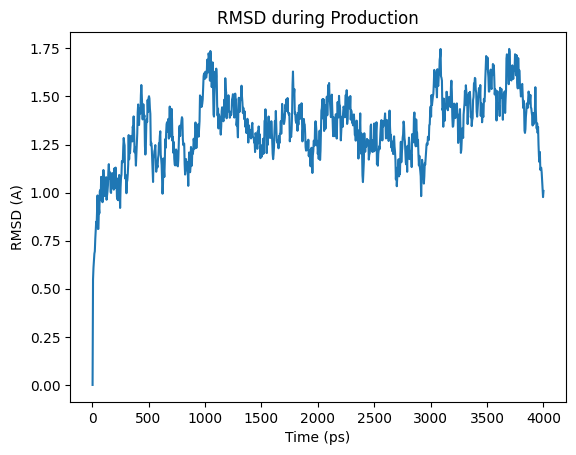

In [12]:
# The RMSD of the system throughout Minimization

file_path = "md/analysis/prod_rmsd.out"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph
plt.plot(data['#Frame'], data['RMSD_00001'])
plt.xlabel('Time (ps)')
plt.ylabel('RMSD (A)')
plt.title('RMSD during Production')

plt.show()

#### 4.4 Distances

In [ ]:
# measure distances between atoms during the simulation
# dist1: VAL93 O - GLY96 N (equal to VAL629 - GLY632) hbond shown in chimeraX
# dist2: GLY90 O - GLY91 O (equal to GLY626 - GLY627)
# Make dists.ptraj file

    """
trajin prod_4ns.mdcrd 
distance d1 :93@O :96@N out dist1.out 
distance d2 :90@O :91@O out dist2.out

    """

In [ ]:
$ cpptraj ../5USZ_sol.prmtop dists.ptraj

# Output file: dist1.out 
# Output file: dist2.out 

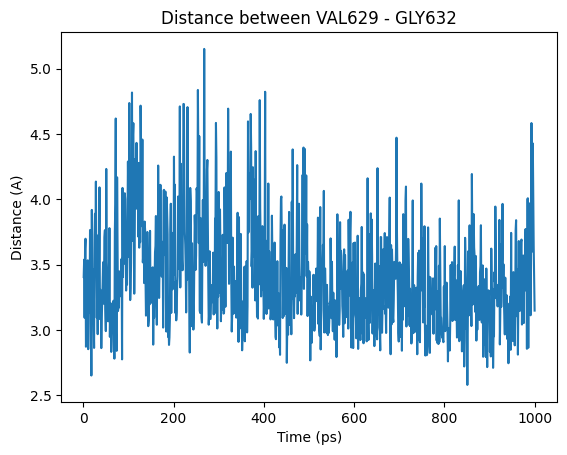

In [3]:
file_path = "md/analysis/dist1.out"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph
plt.plot(data['#Frame'], data['d1'])
plt.xlabel('Time (ps)')
plt.ylabel('Distance (A)')
plt.title('Distance between VAL629 - GLY632')

plt.show()

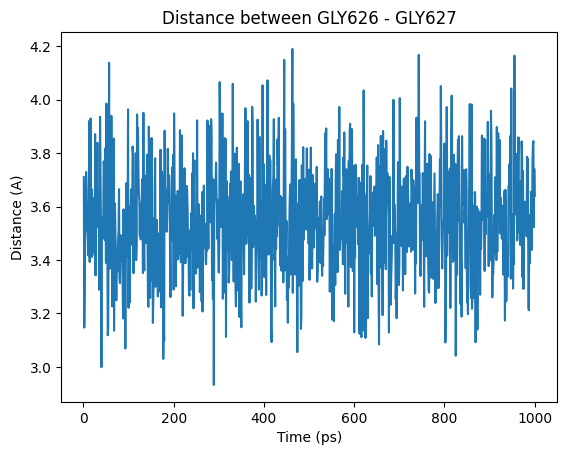

In [2]:
file_path = "md/analysis/dist2.out"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph
plt.plot(data['#Frame'], data['d2'])
plt.xlabel('Time (ps)')
plt.ylabel('Distance (A)')
plt.title('Distance between GLY626 - GLY627')

plt.show()

#### Structural waters 

In [ ]:
# search for structural water molecules which potentially provides and H-bond bridge between two residues
# Make bfactor.ptraj file

    """
trajin prod_4ns.mdcrd 
rms first mass @N,CA,C 
atomicfluct out wat_flucts.out '* & !:1-272' bfactor byres
    """

In [ ]:
$ cpptraj ../5USZ_sol.prmtop bfactor.ptraj

# Output file: wat_flucts.out 

In [ ]:
# A low B-factor indicates low thermal motion
# A high B-factor may imply high thermal motion. 

Min B-factors:
Residue 324.0: 8.64
Residue 315.0: 11.83
Residue 286.0: 12.73
Max B-factors:
Residue 12506.0: 76516.30
Residue 8475.0: 74472.11
Residue 6637.0: 72030.19


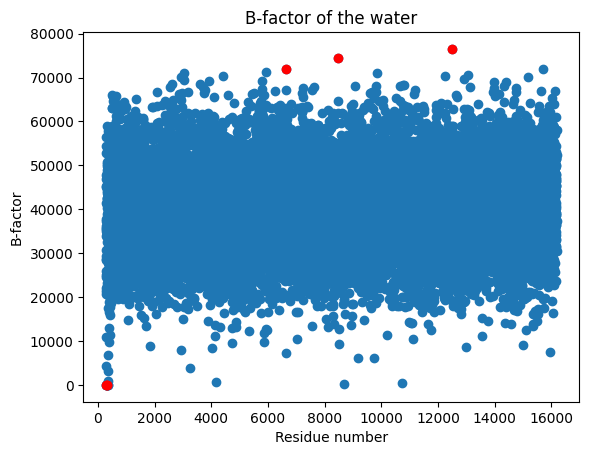

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "md/analysis/wat_flucts.out"
data = pd.read_csv(file_path, sep="\s+")

# Plot the graph as a scatter plot
plt.scatter(data['#Res'], data['B-factors'])
plt.xlabel('Residue number')
plt.ylabel('B-factor')
plt.title('B-factor of the water')

# Identify the indices of the 3 min and 3 max values
min_indices = data['B-factors'].nsmallest(3).index
max_indices = data['B-factors'].nlargest(3).index

# Print the x and y values for the 3 min and 3 max
print("Min B-factors:")
for idx in min_indices:
    print(f"Residue {data.loc[idx, '#Res']}: {data.loc[idx, 'B-factors']:.2f}")

print("Max B-factors:")
for idx in max_indices:
    print(f"Residue {data.loc[idx, '#Res']}: {data.loc[idx, 'B-factors']:.2f}")

# Label the min and max points in red
for idx in min_indices:
    plt.scatter(data.loc[idx, '#Res'], data.loc[idx, 'B-factors'], color='red')
for idx in max_indices:
    plt.scatter(data.loc[idx, '#Res'], data.loc[idx, 'B-factors'], color='red')


plt.show()


In [ ]:
# most water molecules have a high B-factor (around 30, 000), but not all

In [9]:
# Filter the data for B-factors less than 100
filtered_data = data[data['B-factors'] < 100]

# Print the residues with B-factors less than 100
print("Residues with B-factors less than 100:")
for index, row in filtered_data.iterrows():
    print(f"Residue {row['#Res']}: B-factor = {row['B-factors']:.2f}")

Residues with B-factors less than 100:
Residue 286.0: B-factor = 12.73
Residue 289.0: B-factor = 18.98
Residue 306.0: B-factor = 23.83
Residue 315.0: B-factor = 11.83
Residue 324.0: B-factor = 8.64
Residue 332.0: B-factor = 84.04
Residue 333.0: B-factor = 58.53
Residue 339.0: B-factor = 15.76
Residue 364.0: B-factor = 18.57


In [ ]:
# Make small.ptraj file

    """
trajin prod_4ns.mdcrd 1 1000 10
trajout prod_mov.mdcrd

    """

In [ ]:
$ cpptraj ../5USZ_sol.prmtop small.ptraj

# Output file: prod_mov.mdcrd

### Visualizing MD in Chimera

In [ ]:
# Download Chimera
# Tools --> MD/Ensemble Analysis --> MD Movie

# Proptop file: 5USZ_sol.prmtop
# Trajectory file: prod_mov.mdcrd
# Click: OK

In [ ]:
# hide all atoms

$ ~disp

In [ ]:
# show the water with residue number 324 (lowest B-factors)

$ disp :324.water
$ color green,a :324.water
$ disp :324.water z<5